In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn import datasets
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# 데이터 로드
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.Series(california.target)

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
#회귀식
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds= lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
lr_rmse= np.sqrt(mse)

# 일반 cross_val
lr_neg_mse_scores = cross_val_score(lr, X_train, y_train, scoring = 'neg_mean_squared_error',cv=5)
lr_rmse_scores = np.sqrt(-1*lr_neg_mse_scores)
lr_avg_rmse = np.mean(lr_rmse_scores)


# 릿지
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_train, y_train, scoring = 'neg_mean_squared_error',cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('선형회귀', lr_avg_rmse)
print('릿지',avg_rmse)

선형회귀 0.726665763319319
릿지 0.7265690986274753


In [ ]:
# alpha 파라미터값을 조정해서 바꿔보자

alphas = [0,0.1, 1, 10, 100]

# alpha 리스트 평균 rmse

for alpha in alphas:
    ridge=Ridge(alpha= alpha)
    #cross val score cv 5 RMSE
    neg_mse_scores = cross_val_score(ridge,X_train, y_train, scoring = 'neg_mean_squared_error', cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {0}일 때 5 folds의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha 0일 때 5 folds의 평균 RMSE : 0.727
alpha 0.1일 때 5 folds의 평균 RMSE : 0.727
alpha 1일 때 5 folds의 평균 RMSE : 0.727
alpha 10일 때 5 folds의 평균 RMSE : 0.727
alpha 100일 때 5 folds의 평균 RMSE : 0.726


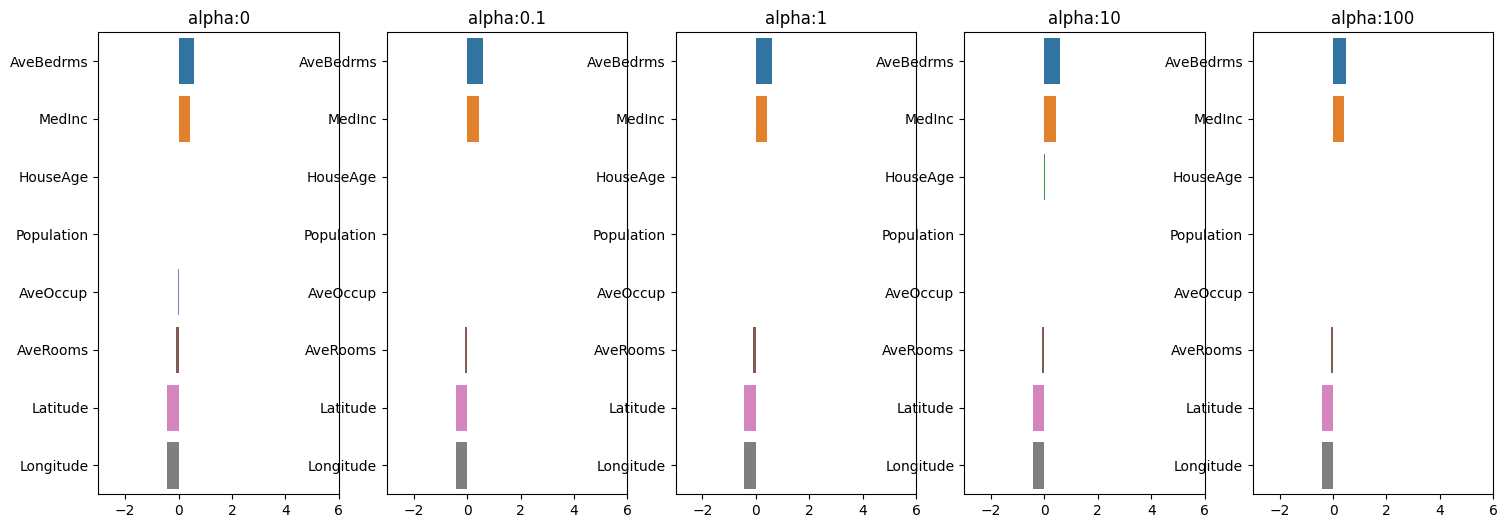

In [ ]:
# 각 alpha에 따른 회귀 계수 값을 시각하기 위해 5개 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize=(18,6), nrows=1, ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하는 데이터 프레임

coeff_df = pd.DataFrame()

#alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장
for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha= alpha)
    ridge.fit(X_train, y_train)
    #alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가
    coeff = pd.Series(data=ridge.coef_, index=X_train.columns)
    colname = 'alpha:'+str(alpha)
    coeff_df[colname]= coeff
    #막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화, 회귀 계수 값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

In [ ]:
ridge_alphas = [0, 0.1,1,10,100]
sort_columns = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_columns, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
AveBedrms,0.593215,0.593103,0.592088,0.582129,0.498470
MedInc,0.433333,0.433322,0.433222,0.432236,0.424056
HouseAge,0.009293,0.009293,0.009295,0.009314,0.009495
Population,-0.000008,-0.000008,-0.000008,-0.000007,-0.000007
AveOccup,-0.004745,-0.004745,-0.004746,-0.004753,-0.004820
AveRooms,-0.098643,-0.098622,-0.098428,-0.096528,-0.080650
Latitude,-0.421449,-0.421447,-0.421424,-0.421190,-0.417966
Longitude,-0.434166,-0.434162,-0.434125,-0.433747,-0.429243


In [ ]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DF 변환
def get_linear_reg_eval(model_name, params = None, X_data_n =None, y_target_n=None,
                       verbose= True, return_coeff=True):
    coeff_df =pd.DataFrame()
    if verbose : print('######', model_name,'#######')
    for param in params:
        if model_name =='Ridge' : model = Ridge(alpha=param)
        elif model_name =='Lasso' : model = Lasso(alpha=param)
        elif model_name =='ElasticNet' : model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n,
                                        y_target_n, scoring= 'neg_mean_squared_error',cv= 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0} 일 때 5 폴드 세트의 평균 RMSE : {1:.3f}'.format(param, avg_rmse))
        #cross_val_score 는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출

        model.fit(X_data_n, y_target_n)
        if return_coeff:
            #alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼 추가
            coeff = pd.Series(data=model.coef_, index =X_data_n.columns)
            colname = 'alpha:'+str(param)
            coeff_df[colname] = coeff
    return coeff_df


In [ ]:
# 라쏘에 사용될 alpha 파라미터 값 정의
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso',params= lasso_alphas, X_data_n =X_train, y_target_n= y_train)

###### Lasso #######
alpha 0.07 일 때 5 폴드 세트의 평균 RMSE : 0.755
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 0.777
alpha 0.5 일 때 5 폴드 세트의 평균 RMSE : 0.850
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 0.972
alpha 3 일 때 5 폴드 세트의 평균 RMSE : 1.156


In [ ]:
# 반환된 coeff_lasso_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DF 출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
MedInc,0.388982,0.392703,0.291943,0.149781,0.000000
HouseAge,0.013326,0.015028,0.011999,0.005873,0.000000
Population,0.000007,0.000015,0.000010,-0.000008,-0.000025
AveRooms,0.000000,-0.000000,0.000000,0.000000,0.000000
AveBedrms,0.000000,0.000000,-0.000000,-0.000000,-0.000000
AveOccup,-0.004270,-0.003972,-0.000000,-0.000000,-0.000000
Longitude,-0.201599,-0.095754,-0.000000,-0.000000,-0.000000
Latitude,-0.209582,-0.110580,-0.000000,-0.000000,-0.000000


In [ ]:
#엘라스틱넷에 사용될 alpha 파라미터 값 정의하고 함수 도출
# l1_ratio는 0.7로 고정

elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet',params = elastic_alphas,
                                      X_data_n = X_train, y_target_n = y_train)

###### ElasticNet #######
alpha 0.07 일 때 5 폴드 세트의 평균 RMSE : 0.746
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 0.758
alpha 0.5 일 때 5 폴드 세트의 평균 RMSE : 0.833
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 0.906
alpha 3 일 때 5 폴드 세트의 평균 RMSE : 1.156


In [ ]:
sort_columns = 'alpha:'+ str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_columns, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
MedInc,0.386292,0.387895,0.321150,2.168930e-01,0.000000
HouseAge,0.012460,0.013629,0.013581,9.165669e-03,0.000000
Population,0.000004,0.000009,0.000015,6.448891e-07,-0.000026
AveRooms,0.000000,-0.000000,0.000000,0.000000e+00,0.000000
AveBedrms,0.000000,0.000000,-0.000000,-0.000000e+00,-0.000000
AveOccup,-0.004553,-0.004342,-0.000000,-0.000000e+00,-0.000000
Longitude,-0.256860,-0.182910,-0.000000,-0.000000e+00,-0.000000
Latitude,-0.261287,-0.192127,-0.000000,-0.000000e+00,-0.000000


In [ ]:
#mehtod는 표준 정규 분포 변환( Standard), 최댓값/최솟값 정규화(MinMax), 로그변환(Log) 결정
#p_degree는 다항식 특성 추가할 때 적용, p_degree는 2이상 부여하지 않음
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method =='Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method =='MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method =='Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree !=None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias =False).fit_transform(scaled_data)

    return scaled_data

In [ ]:
#Ridged의 alpha값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE추출
alphas = [0.1, 1, 10, 100]

# 5개 방식으로 변환, 먼저 원본 그대로, 표준정규 분포, 표준정규 분포 +다항식 특성
# 최대/최소 정규화, 최대/최소 정규화 + 다항식 특성, 로그변환 등 자유롭게 조절 가능
scale_methods =[(None, None),('Standard',None),('Standard',2),
               ('MinMax',None),('MinMax',2)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method = scale_method[0], p_degree = scale_method[1], input_data =X_train)

    print('\n## 변환 유형 :{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params= alphas, X_data_n = X_data_scaled,
                       y_target_n = y_train, verbose=False, return_coeff =False)


## 변환 유형 :None, Polynomial Degree:None
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 0.727
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 0.727
alpha 10 일 때 5 폴드 세트의 평균 RMSE : 0.727
alpha 100 일 때 5 폴드 세트의 평균 RMSE : 0.726

## 변환 유형 :Standard, Polynomial Degree:None
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 0.727
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 0.727
alpha 10 일 때 5 폴드 세트의 평균 RMSE : 0.727
alpha 100 일 때 5 폴드 세트의 평균 RMSE : 0.727

## 변환 유형 :Standard, Polynomial Degree:2
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 1.611
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 1.574
alpha 10 일 때 5 폴드 세트의 평균 RMSE : 1.329
alpha 100 일 때 5 폴드 세트의 평균 RMSE : 0.838

## 변환 유형 :MinMax, Polynomial Degree:None
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 0.726
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 0.729
alpha 10 일 때 5 폴드 세트의 평균 RMSE : 0.735
alpha 100 일 때 5 폴드 세트의 평균 RMSE : 0.802

## 변환 유형 :MinMax, Polynomial Degree:2
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 0.696
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 0.711
alpha 10 일 때 5 폴드 세트의 평균 RMSE : 0.727
alpha 100 일 때 5 폴드 세트의 평균 RMSE : 0.768


- **Ridge Regression (L2 Regularization)**

----
> 주요 하이퍼파라미터
alpha:
설명: 정규화 강도를 조절하는 파라미터입니다. 값이 클수록 규제(regularization) 강도가 강해져 가중치가 더 작아집니다.
역할: 모델이 과적합되는 것을 방지합니다. alpha가 너무 크면 모델이 과대적합되기 쉬우며, 너무 작으면 모델이 과소적합될 수 있습니다.
범위: 일반적으로 0 이상. 0에 가까우면 규제가 약해지고, 큰 값이면 규제가 강해집니다.

----
- **Lasso Regression (L1 Regularization)**
> 주요 하이퍼파라미터
alpha:
설명: 정규화 강도를 조절하는 파라미터입니다. 값이 클수록 규제가 강해져 많은 가중치가 0으로 수렴합니다.
역할: 특성 선택 효과를 제공하여 일부 가중치를 0으로 만듭니다. 이는 모델을 희소하게 만들어 해석력을 높입니다.
범위: 일반적으로 0 이상. 0에 가까우면 규제가 약해지고, 큰 값이면 규제가 강해집니다.

----
- **ElasticNet**
> 주요 하이퍼파라미터
> - alpha:
설명: L1과 L2 정규화의 전체 강도를 조절하는 파라미터입니다.
역할: 모델이 과적합되는 것을 방지합니다. alpha가 너무 크면 모델이 과대적합되기 쉬우며, 너무 작으면 모델이 과소적합될 수 있습니다.
범위: 일반적으로 0 이상. 0에 가까우면 규제가 약해지고, 큰 값이면 규제가 강해집니다.
> - l1_ratio:
설명: L1 정규화와 L2 정규화 간의 비율을 조절하는 파라미터입니다. 0이면 Ridge, 1이면 Lasso와 유사해집니다.
역할: L1과 L2 규제를 혼합하여 모델을 최적화합니다. l1_ratio가 0에 가까울수록 L2 규제가 강해지고, 1에 가까울수록 L1 규제가 강해집니다.
범위: 0과 1 사이의 값.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error

# 데이터 로드
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.Series(california.target)

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Linear Regression MSE: 0.5290


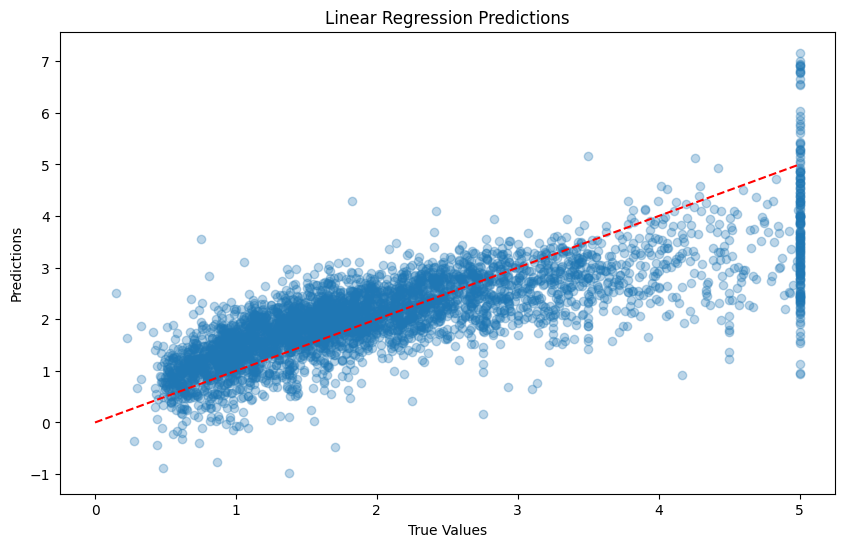

In [ ]:
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_linear = linear_reg.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f"Linear Regression MSE: {mse_linear:.4f}")

# 시각화 함수
def plot_predictions(y_test, y_pred, title, alpha=None):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([0, 5], [0, 5], '--r')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    if alpha is not None:
        plt.title(f"{title} (Alpha={alpha})")
    else:
        plt.title(title)
    plt.show()

plot_predictions(y_test, y_pred_linear, 'Linear Regression Predictions')


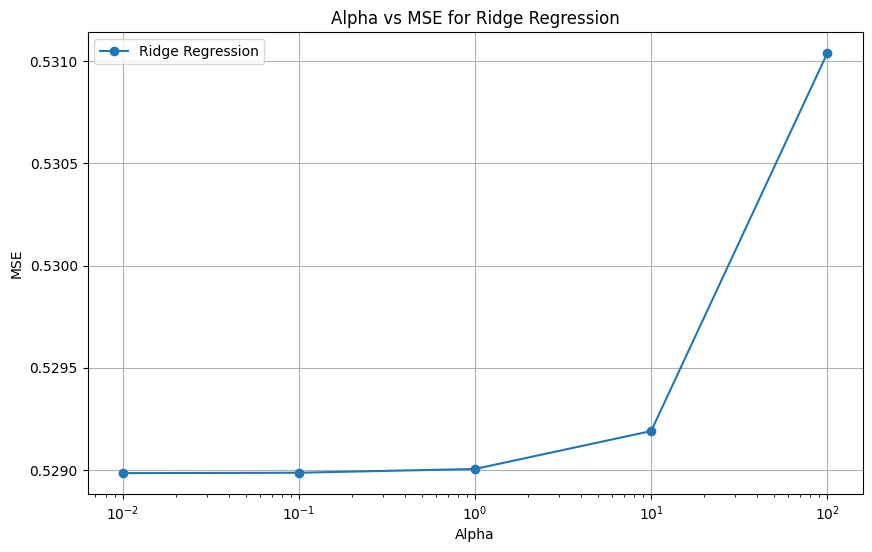

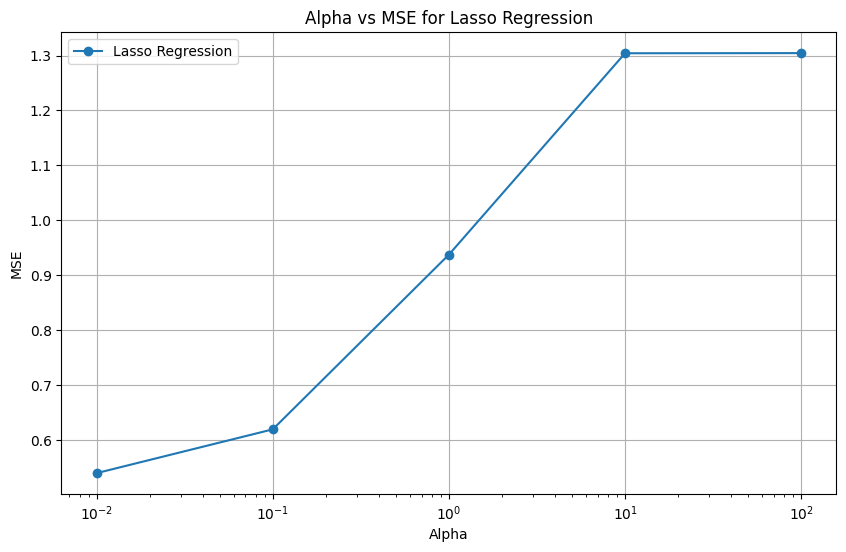

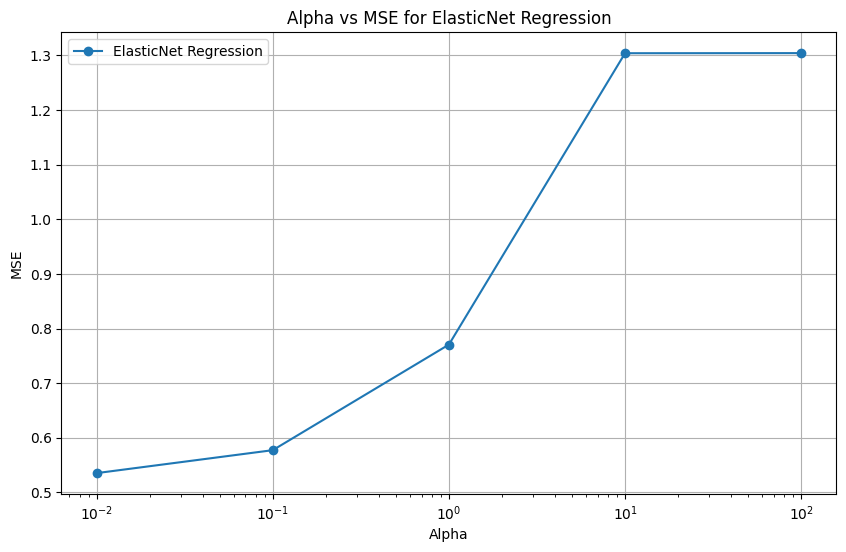

In [ ]:
# Ridge Regression
alpha_values = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge_mse = []
ridge_predictions = {}

for alpha in alpha_values:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    ridge_mse.append(mse)
    ridge_predictions[alpha] = y_pred

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, ridge_mse, marker='o', label='Ridge Regression')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Alpha vs MSE for Ridge Regression')
plt.grid(True)
plt.legend()
plt.show()

# Lasso Regression
lasso_mse = []
lasso_predictions = {}

for alpha in alpha_values:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    lasso_mse.append(mse)
    lasso_predictions[alpha] = y_pred

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, lasso_mse, marker='o', label='Lasso Regression')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Alpha vs MSE for Lasso Regression')
plt.grid(True)
plt.legend()
plt.show()

# ElasticNet Regression
elasticnet_mse = []
elasticnet_predictions = {}
l1_ratio = 0.5  # ElasticNet에서 L1과 L2 비율 고정

for alpha in alpha_values:
    elasticnet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    elasticnet.fit(X_train, y_train)
    y_pred = elasticnet.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    elasticnet_mse.append(mse)
    elasticnet_predictions[alpha] = y_pred

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, elasticnet_mse, marker='o', label='ElasticNet Regression')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Alpha vs MSE for ElasticNet Regression')
plt.grid(True)
plt.legend()
plt.show()


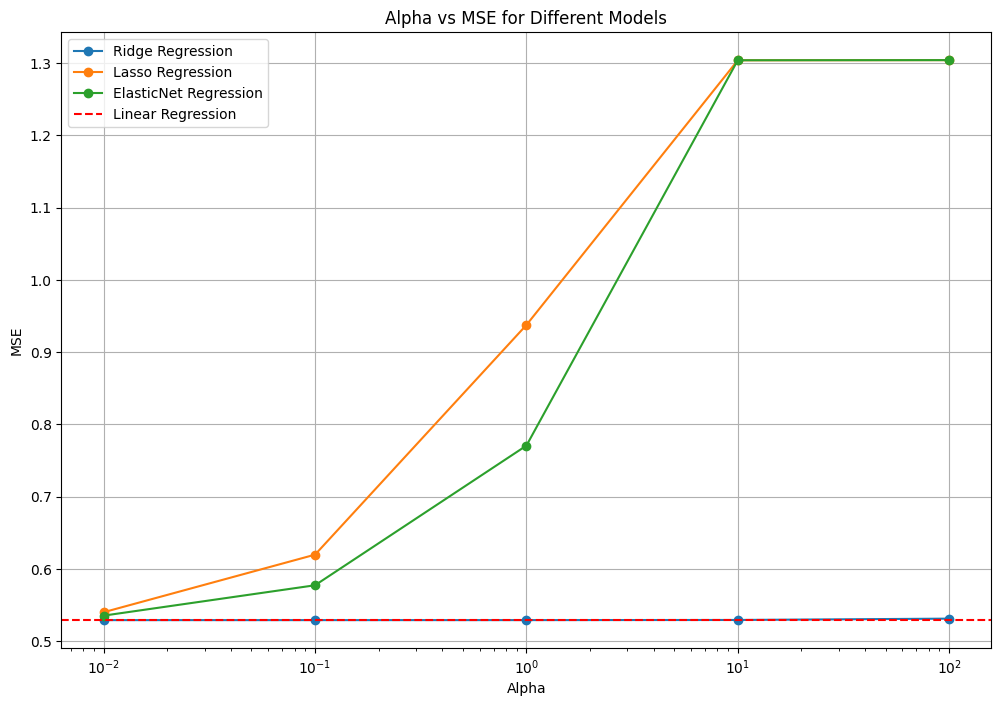

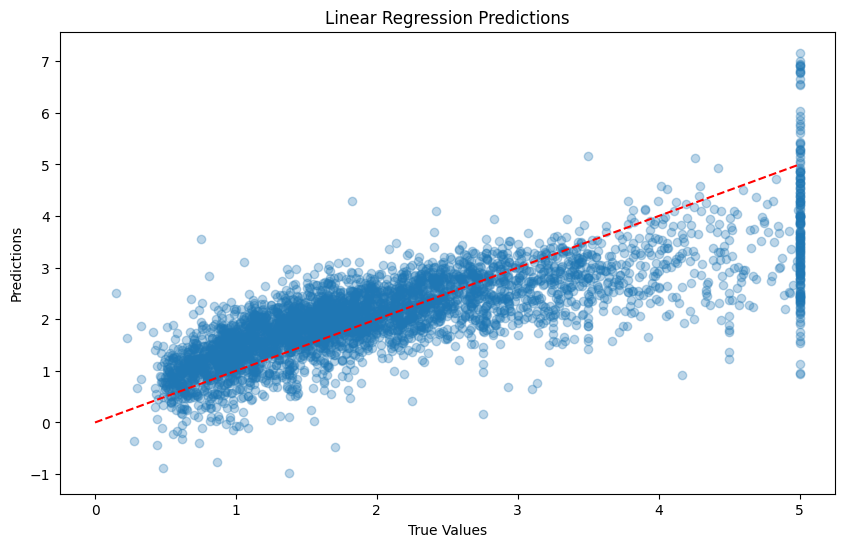

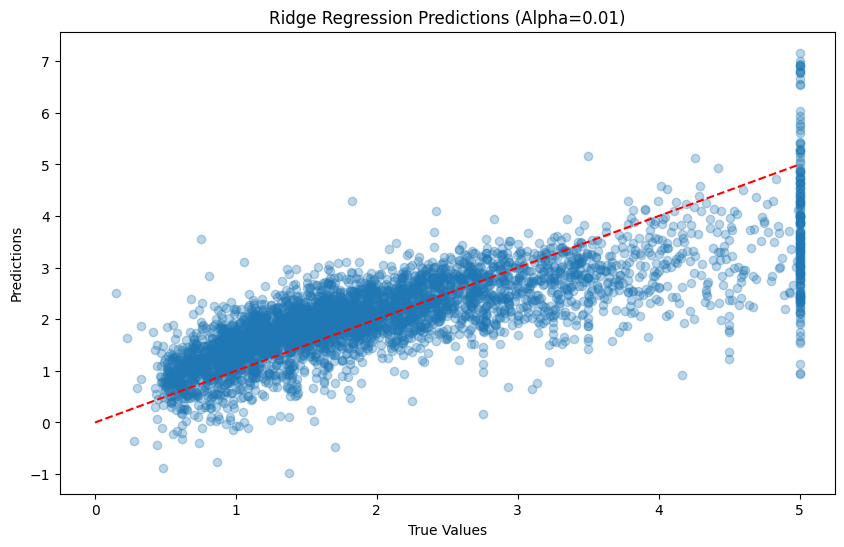

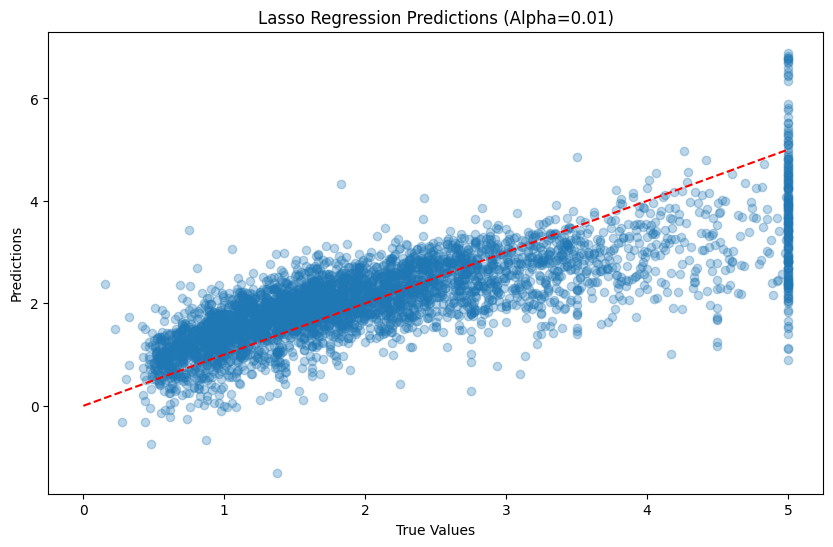

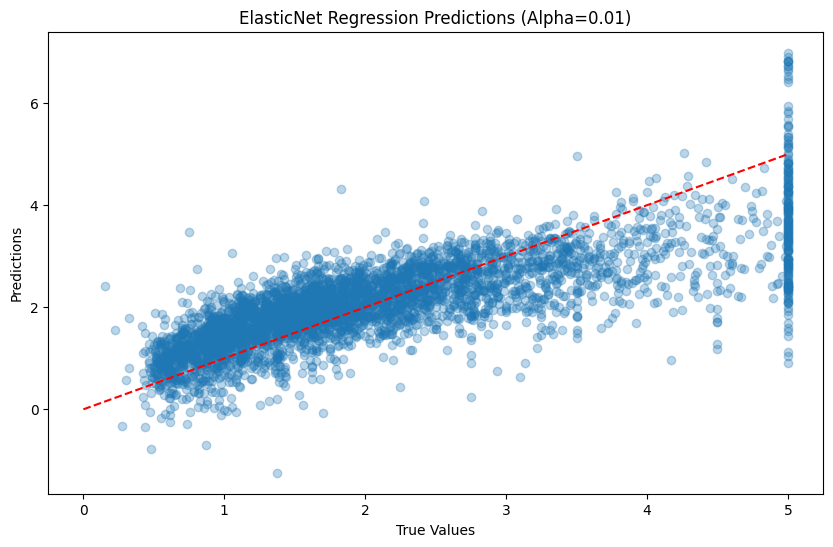

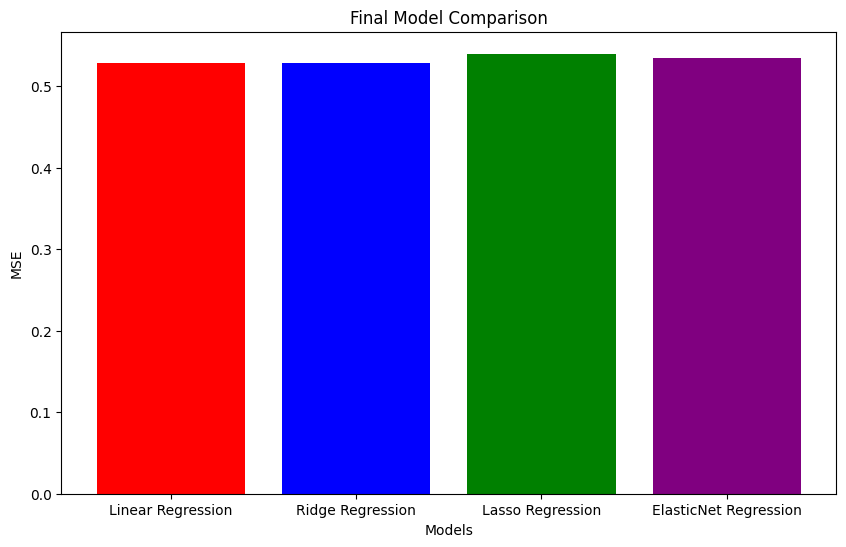

최적 모델: Linear Regression with MSE: 0.5290


In [ ]:
# 모든 모델의 MSE 시각화
plt.figure(figsize=(12, 8))

plt.plot(alpha_values, ridge_mse, marker='o', label='Ridge Regression')
plt.plot(alpha_values, lasso_mse, marker='o', label='Lasso Regression')
plt.plot(alpha_values, elasticnet_mse, marker='o', label='ElasticNet Regression')

plt.axhline(y=mse_linear, color='r', linestyle='--', label='Linear Regression')

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Alpha vs MSE for Different Models')
plt.legend()
plt.grid(True)
plt.show()

# 가장 좋은 결과를 낸 alpha 값 찾기
best_alpha_ridge = alpha_values[np.argmin(ridge_mse)]
best_alpha_lasso = alpha_values[np.argmin(lasso_mse)]
best_alpha_elasticnet = alpha_values[np.argmin(elasticnet_mse)]

# 회귀선 시각화
plot_predictions(y_test, y_pred_linear, 'Linear Regression Predictions')
plot_predictions(y_test, ridge_predictions[best_alpha_ridge], 'Ridge Regression Predictions', alpha=best_alpha_ridge)
plot_predictions(y_test, lasso_predictions[best_alpha_lasso], 'Lasso Regression Predictions', alpha=best_alpha_lasso)
plot_predictions(y_test, elasticnet_predictions[best_alpha_elasticnet], 'ElasticNet Regression Predictions', alpha=best_alpha_elasticnet)

# 최종 성능 비교
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet Regression']
mse_values = [mse_linear, np.min(ridge_mse), np.min(lasso_mse), np.min(elasticnet_mse)]

plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, color=['red', 'blue', 'green', 'purple'])
plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('Final Model Comparison')
plt.show()

# 최적 모델 선택
best_model_index = np.argmin(mse_values)
best_model = models[best_model_index]
print(f"최적 모델: {best_model} with MSE: {mse_values[best_model_index]:.4f}")